In [10]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32

DATASET_ROOT = "data/HQ-50K"

In [11]:
def load_and_crop_images(folder, img_size=64):
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff")
    images = []

    for path in glob.iglob(os.path.join(folder, "**", "*"), recursive=True):
        if path.lower().endswith(exts):
            try:
                img = Image.open(path).convert("RGB")
                img = img.resize((img_size, img_size))
                images.append(np.array(img))
            except Exception as e:
                print(f"Skipping {path}: {e}")

    images = np.array(images, dtype=np.float32)
    images = (images - 127.5) / 127.5  #normalize to [-1, 1]
    return images

all_images = load_and_crop_images(DATASET_ROOT)
print("Loaded images shape:", all_images.shape)

#separate into train and test at 0.1 ratio
train_images, test_images = train_test_split(all_images, test_size=0.1, random_state=42)
print("Train:", train_images.shape, "Test:", test_images.shape)

dataset = tf.data.Dataset.from_tensor_slices(train_images)
#add Gaussian blur to clean images to create pairs
dataset = dataset.map(lambda x: (tf.clip_by_value(x + tf.random.normal(tf.shape(x), stddev=0.1), -1.0, 1.0), x))
dataset = dataset.shuffle(1000).batch(BATCH_SIZE)
print("Train:", train_images.shape, "Test:", test_images.shape)

Loaded images shape: (38506, 64, 64, 3)
Train: (34655, 64, 64, 3) Test: (3851, 64, 64, 3)
Train: (34655, 64, 64, 3) Test: (3851, 64, 64, 3)


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

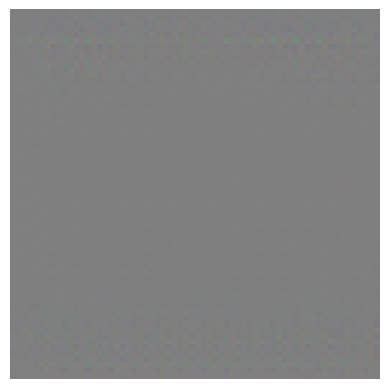

In [12]:
def make_generator_model():
    inputs = tf.keras.Input(shape=(64, 64, 3))

    #downsample
    x = layers.Conv2D(64, (5, 5), strides=2, padding="same")(inputs)   # 32x32
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, (5, 5), strides=2, padding="same")(x)      # 16x16
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    #upsample
    x = layers.Conv2DTranspose(128, (5, 5), strides=2, padding="same")(x)  # 32x32
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(64, (5, 5), strides=2, padding="same")(x)   # 64x64
    x = layers.LeakyReLU()(x)

    outputs = layers.Conv2D(3, (5, 5), activation="tanh", padding="same")(x)
    return tf.keras.Model(inputs, outputs)

generator = make_generator_model()

sample_noisy = train_images[0:1]
generated_image = generator(sample_noisy, training=False)

plt.imshow((generated_image[0] * 0.5 + 0.5))
plt.axis("off")

In [13]:
def make_discriminator_model():
    noisy_input = tf.keras.Input(shape=(64, 64, 3))
    clean_input = tf.keras.Input(shape=(64, 64, 3))

    x = tf.keras.layers.Concatenate()([noisy_input, clean_input])

    #reduce down to 1 layer
    x = layers.Conv2D(64, (5, 5), strides=2, padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, (5, 5), strides=2, padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, (5, 5), strides=2, padding="same")(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    return tf.keras.Model([noisy_input, clean_input], x)

discriminator = make_discriminator_model()
sample_noisy_tensor = tf.convert_to_tensor(sample_noisy, dtype=tf.float32)
decision = discriminator([sample_noisy_tensor, generated_image])
print(decision)

tf.Tensor([[-0.02010058]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.02010058]], shape=(1, 1), dtype=float32)


In [14]:
#calculate cross entropy for loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

LAMBDA = 100 #use lambda to control importance of L1

def generator_loss(fake_output, real_image, generated_image):
    adv_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(real_image - generated_image))
    return adv_loss + LAMBDA * l1_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
print("Optimizers complete.")

Optimizers complete.


In [15]:
#50 is destroying my laptop since I have no GPU, trying 20
EPOCHS = 50

@tf.function
def train_step(noisy_batch, clean_batch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noisy_batch, training=True)

        real_output = discriminator([noisy_batch, clean_batch], training=True)
        fake_output = discriminator([noisy_batch, generated_images], training=True)

        gen_loss = generator_loss(fake_output, clean_batch, generated_images)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

for epoch in range(EPOCHS):
    for noisy_batch, clean_batch in dataset:
        train_step(noisy_batch, clean_batch)
    print(f"Epoch {epoch+1}/{EPOCHS} complete")
    
    #image every 5 gens to see progress
    if (epoch+1) % 5 == 0:
        generate_and_save_images(generator, epoch+1, sample_noisy)

E0000 00:00:1761795152.788864   43885 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/functional_4_3/leaky_re_lu_16_1/LeakyRelu/LeakyReluGrad_1' exist for missing node 'functional_4_3/conv2d_14_1/BiasAdd'.
E0000 00:00:1761795612.482183   43885 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/functional_4_1/leaky_re_lu_15_1/LeakyRelu/LeakyReluGrad' exist for missing node 'functional_4_1/conv2d_13_1/BiasAdd'.
2025-10-29 23:40:12.955648: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/50 complete


KeyboardInterrupt: 

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  #inference mode
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i] * 0.5 + 0.5))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()